# **Deep-learning enabled single-shot 3D feature detection in fringe projection profilometry**

### **Students:** Juan Peña and Eberto Benjumea

### **Professor:** Andres Marrugo

## **Problem**

Fringe Projection Profilometry (FPP) is a widely used technique based on structured illumination for optical three-dimensional (3D) shape measurement. It provides a 3D topography of objects in a non-contact manner, with high resolution, and fast data processing.
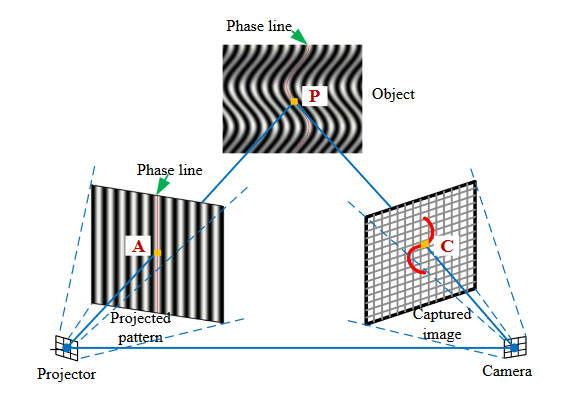

**Fig 1.** Fringe projection system


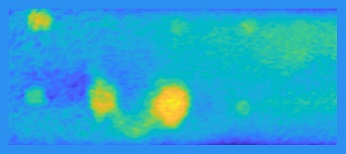

**Fig 2.** 3D image.

The detection of features in a 3D reconstruction represents a challenge in image processing. For this, traditionally a preprocessing is performed and tailored algorithms are designed and implemented for each case. As an alternative to these conventional methods, machine learning and deep learning strategies have been proposed. These require many images, which additionally have to be manually labeled, to accomplish this task.

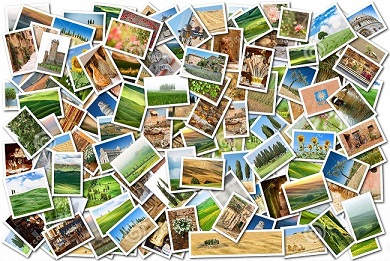

## **Aim**

We propose a method for 3D feature detection by using a convolutional neural network and a single 3D image obtained by fringe projection profilometry. 

We cast the problem of 3D feature detection as an unsupervised detection problem. Hence, the goal is to use a neural network that learns to detect specific features in 3D images using a single unlabeled image. Therefore, we implemented a recently reported deep-learning method called “LodeSTAR” (Low-shot deep Symmetric Tracking and Regression) that exploits inherent symmetries to detect objects with few training data and without ground truth. 

In [7]:
%matplotlib inline
!pip install deeptrack

In [8]:
import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

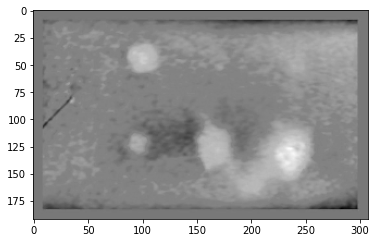

In [32]:
import cv2
n = 1
image = dt.LoadImage(f"../input/wheals-data/Data/jpg/test/images/{n}.jpg")()._value / 256
gray_image = 0.21*image[:,:,0] + 0.72*image[:,:,1] + 0.07*image[:,:,2] # Convert to grayscale manually
resize_image = cv2.resize(gray_image, (0, 0), fx=0.3, fy=0.3)
plt.figure()
plt.imshow(resize_image, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

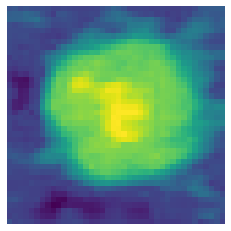

In [33]:
t, x, y, w = (251, 80, 25, 40)
#resize_image = cv2.resize(gray_image, (0, 0), fx=0.3, fy=0.3)
crop = resize_image[y:y+w, x:x+w]
plt.figure()
plt.imshow(crop)
plt.axis("off")
plt.show

In [34]:
training_image = np.expand_dims(crop, axis = 2) # Add a third channel
print(crop.shape)
print(training_image.shape)

(40, 40)
(40, 40, 1)


In [35]:
model = dt.models.LodeSTAR(input_shape=(None, None, 1))

train_set =   (
    dt.Value(training_image)
    >> dt.Add(lambda: np.random.randn() * 0.1)
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))  
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)
# model.model.consistency_weight = X
model.fit(
    train_set,
    epochs=100,
    batch_size=8,
)

2022-10-24 16:29:32.524125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 16:29:32.524960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 16:29:32.526099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 16:29:32.526852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Generating 163 / 160 samples before starting training


2022-10-24 16:29:52.174275: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-10-24 16:29:58.880040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
163/163 [==============================] - 9s 16ms/step - total_loss: 2.9403 - consistency_loss: 1.4942
Epoch 2/100
163/163 [==============================] - 3s 18ms/step - total_loss: 2.7396 - consistency_loss: 1.4455
Epoch 3/100
163/163 [==============================] - 3s 17ms/step - total_loss: 1.9042 - consistency_loss: 1.0205
Epoch 4/100
163/163 [==============================] - 3s 18ms/step - total_loss: 1.8742 - consistency_loss: 1.0370
Epoch 5/100
163/163 [==============================] - 3s 19ms/step - total_loss: 3.1155 - consistency_loss: 1.6036
Epoch 6/100
163/163 [==============================] - 3s 18ms/step - total_loss: 2.7724 - consistency_loss: 1.4076
Epoch 7/100
163/163 [==============================] - 3s 18ms/step - total_loss: 1.4567 - consistency_loss: 0.8567
Epoch 8/100
163/163 [==============================] - 3s 18ms/step - total_loss: 1.4725 - consistency_loss: 0.8804
Epoch 9/100
163/163 [==============================] - 3s 18ms/step - to

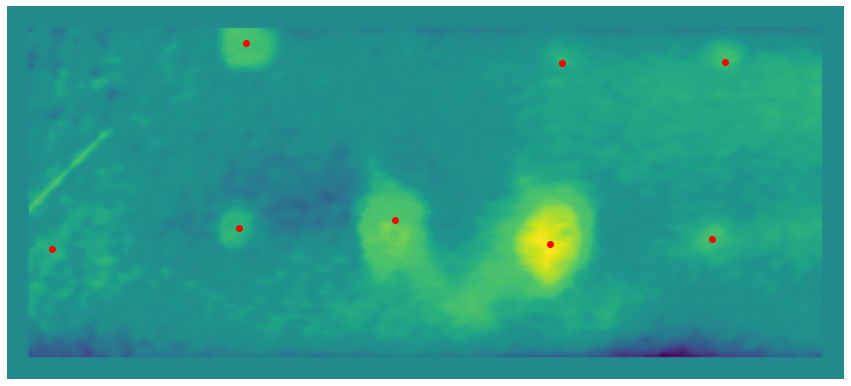

In [41]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

m = 2
image_test = dt.LoadImage(f"../input/wheals-data/Data/jpg/train/images/{m}.jpg")()._value / 256
imaget = cv2.resize(image_test, (0, 0), fx=0.3, fy=0.3)
gray_imaget = 0.21*imaget[:,:,0] + 0.72*imaget[:,:,1] + 0.07*imaget[:,:,2] 
test_image = np.expand_dims(gray_imaget, axis = 2)

detections = model.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
# detections = autotracker.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant")

plt.figure(figsize=(15, 15))
plt.imshow(test_image)
plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")